In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

2022-12-19 15:43:23.140147: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-19 15:43:27.934199: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-19 15:43:28.360565: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import moscot
from moscot.problems.time import TemporalProblem
import moscot.plotting as mpl
import pandas as pd
import os

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200)
                         
import mplscience

mplscience.available_styles()
mplscience.set_style(reset_current=True)
plt.rcParams['legend.scatterpoints'] = 1 

2022-12-19 15:45:11.405690: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-19 15:45:11.405871: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)


['default', 'despine']


In [3]:
output_dir = "."

In [5]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_processed.h5ad")

In [6]:
adata_2 = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/embeddings/pancreas_shared_embeddings.h5ad")

In [7]:
adata.obsm["X_multi_vi"] = adata_2.obsm["X_multi_vi"]

In [8]:
new_annotation = pd.read_csv("../EDA/endocrine_refinement.csv")

In [9]:
adata.obs["Fev_delta_refinement"] = new_annotation["Fev_delta_refinement"].values
adata.obs["Ngn3_high_refinement"] = new_annotation["Ngn3_high_refinement"].values
adata.obs["refinement"] = new_annotation["refinement"].values

In [10]:
adata_2 = sc.read_h5ad("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_processed.h5ad")

In [11]:
chromvar_features = pd.read_csv("/lustre/groups/ml01/workspace/moscot_paper/pancreas/JASPAR_chromvar_annotations_reduced.csv")

In [12]:
chromvar_features.set_index("Unnamed: 0", inplace=True)

In [13]:
chromvar_features = chromvar_features.T

In [14]:
chromvar_features["old_index"] = chromvar_features.index

In [15]:
def rename_index(x):
    split = x["old_index"].split("_")
    if split[0] == "E14-5":
        return split[1]+"-0"
    if split[0] == "E15-5":
        return split[1]+"-1"
    raise ValueError("Pattern does not match")

In [16]:
chromvar_features["index_adapted"] = chromvar_features.apply(rename_index ,axis=1)

In [17]:
chromvar_features.set_index("index_adapted", inplace=True)

In [18]:
endocrine_celltypes = [
    "Ngn3 low",
    "Ngn3 high",
    "Ngn3 high cycling",
    "Fev+",
    "Fev+ Alpha",
    "Fev+ Beta",
    "Fev+ Delta",
    "Eps. progenitors",
    "Alpha",
    "Beta",
    "Delta",
    "Epsilon"
]

In [19]:
adata_red = adata_2[adata_2.obs["celltype"].isin(endocrine_celltypes)].copy()
adata = adata[adata.obs["celltype"].isin(endocrine_celltypes)].copy()

In [20]:
sc.tl.umap(adata_red)

In [21]:
adata.obs['time'] = adata.obs.apply(lambda x: 14.5 if x["sample"]=="E14.5" else 15.5, axis=1)

In [22]:
adata.obsm["umap"] = adata_red.obsm["umap"].copy()

In [23]:
adata.obs = adata.obs.merge(chromvar_features, left_index=True, right_index=True)

In [24]:
color_dict = { 'Prlf. Ductal': '#f7b6d2', 'Ductal': '#d62728', 'Imm. Acinar': '#ffbb78', 'Mat. Acinar': '#98df8a',
    'Alpha': '#1f77b4', 'Beta': '#ff7f0e', 'Delta': '#279e68', 'Eps. progenitors': '#aa40fc', 'Epsilon': '#8c564b',
       'Fev+': '#e377c2', 'Fev+ Alpha': '#b5bd61', 'Fev+ Beta': '#aec7e8', 'Fev+ Delta': '#aec7e8', 'Fev+ Delta,0': '#ffbb78', 'Fev+ Delta,1':'#98df8a',
        'Fev+ Delta,2': '#17becf', 'Ngn3 high cycling': '#aec7e8',
        'Ngn3 high,0': '#ff9896', 'Ngn3 high,1':'#f0b98d', 'Ngn3 low': '#c5b0d5'
}

In [25]:
adata.obs["refinement"] = adata.obs["refinement"].astype("category")
adata.uns["refinement_colors"] = [color_dict[ct] for ct in adata.obs["refinement"].cat.categories]

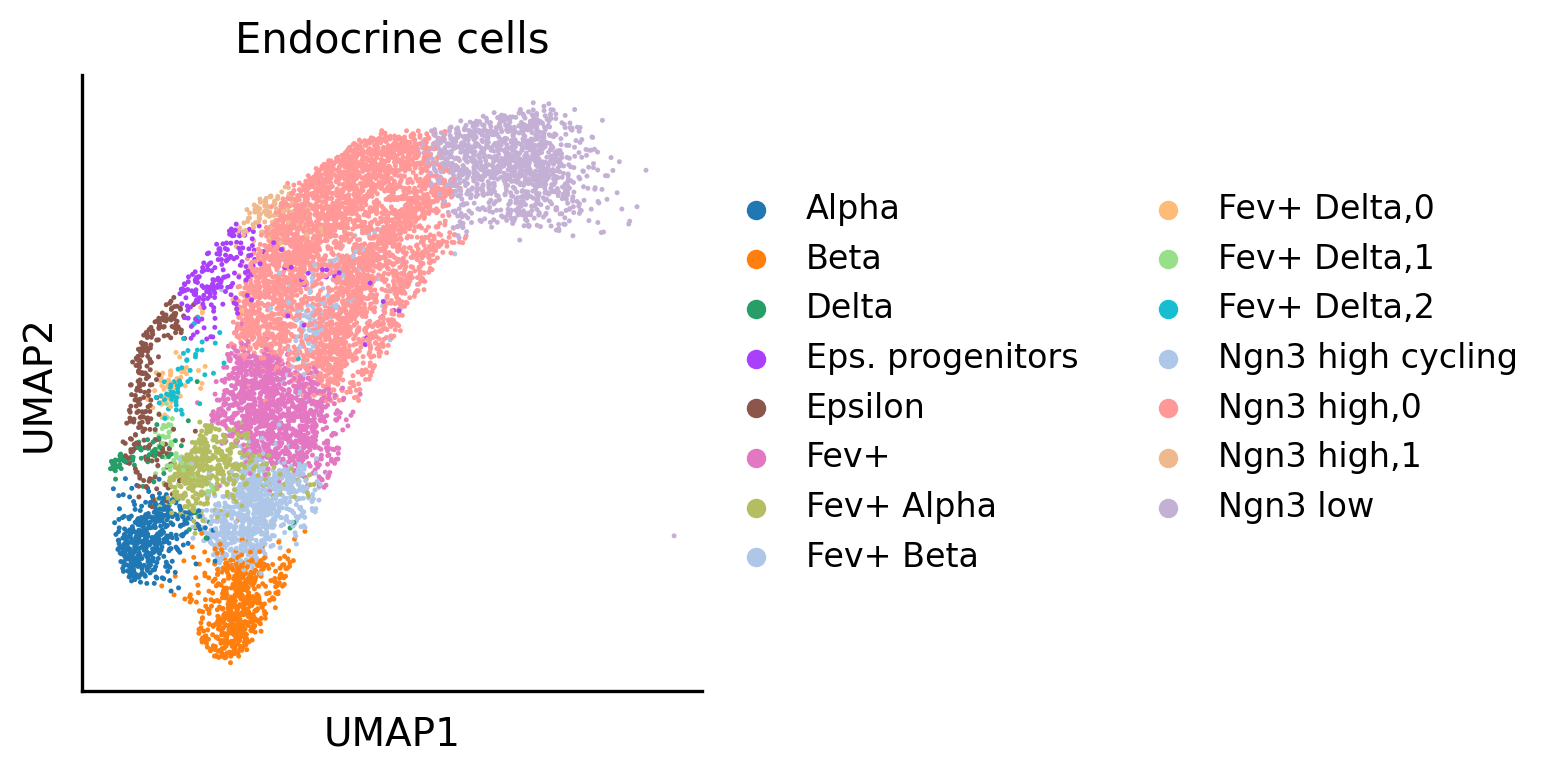

In [26]:
fig = sc.pl.umap(adata, color="refinement", show=True, return_fig=True, title="Endocrine cells")
fig

In [27]:
#fig.figure.savefig(os.path.join(output_dir, 'umap_endocrine_refinement_grouped.png'))

In [28]:
label_params = fig.axes[0].get_legend_handles_labels() 
figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, fontsize=5, loc="center", markerscale=2, bbox_to_anchor=(0.5, 0.5), prop={"size":10})

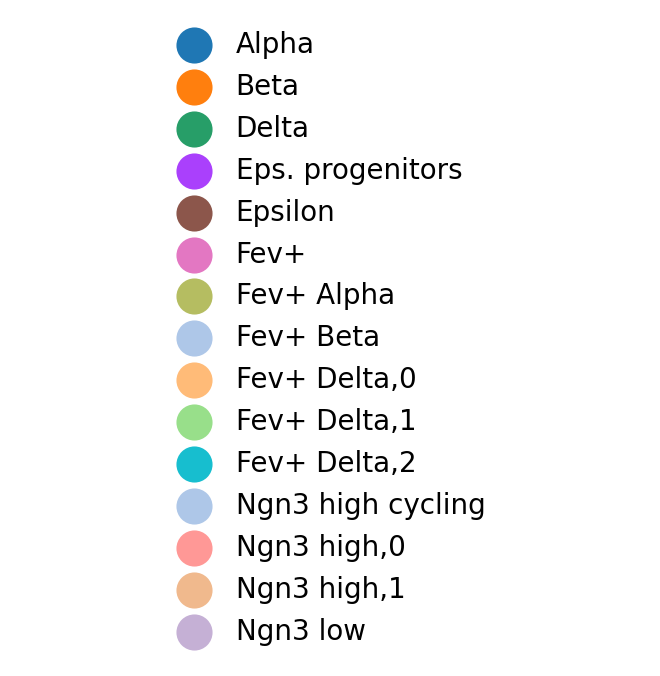

In [29]:
axl.figure

In [30]:
#axl.figure.savefig(os.path.join(output_dir, 'endocrine_refinement_grouped_legend_only.png'))

# Heat kernel distances

In [31]:
import pygsp

In [32]:
sc.pp.neighbors(adata, use_rep="X_multi_vi", key_added="multi_vi", n_neighbors=30)

In [33]:
cell_ids_source = adata[adata.obs["time"]==14.5].obs_names
cell_ids_target = adata[adata.obs["time"]==15.5].obs_names

In [34]:
assert (adata.obs.iloc[:(len(cell_ids_source))].index == cell_ids_source).all()
assert (adata.obs.iloc[(len(cell_ids_source)):].index == cell_ids_target).all()

In [35]:
G = pygsp.graphs.Graph(adata.obsp["multi_vi_connectivities"])

In [36]:
G.estimate_lmax()

In [37]:
filt = pygsp.filters.Heat(G, tau=100)
diffusion_distances = filt.filter(np.eye(len(adata)))
custom_cost = pd.DataFrame(data=-np.log(diffusion_distances[:len(cell_ids_source), len(cell_ids_source):].copy())+1e-15, index=cell_ids_source, columns=cell_ids_target)

In [38]:
tp0 = TemporalProblem(adata)
tp0 = tp0.prepare("time", joint_attr="X_multi_vi")

In [39]:
tp0[14.5, 15.5].set_xy(custom_cost, tag="cost_matrix")

In [40]:
tp0 = tp0.solve(max_iterations=1e8)

INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5539, 3826)].            


In [41]:
tp0.save("/lustre/groups/ml01/workspace/moscot_paper/pancreas/", file_prefix="JASPAR", overwrite=True)

INFO     Successfully saved the problem as                                                   
         `/lustre/groups/ml01/workspace/moscot_paper/pancreas/JASPAR_TemporalProblem.pkl`    
